11 ноября 1821 – 9 февраля 1881 гг.

1846 — Двойник
1855 — На первое июля 1855 года
1865 - Преступление и наказание
1870—1872 — Бесы
1875— Подросток
1880 — Пушкин

In [1]:
import nltk
import nltk.tokenize
import timeit
import spacy
import string
from spacy.lang.ru.examples import sentences
from spacy.lang.ru import Russian
import pandas as pd
import numpy as np
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from pymorphy3 import MorphAnalyzer
# from nltk.stem import SnowballStemmer
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud
from collections import Counter


In [82]:
from nltk.tokenize import sent_tokenize
from spacy import displacy
from nltk.corpus import cmudict
import numpy as np
from nltk.tokenize import word_tokenize

In [3]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

ValueError: [E088] Text of length 1271780 exceeds maximum of 1000000. The parser and NER models require roughly 1GB of temporary memory per 100,000 characters in the input. This means long texts may cause memory allocation errors. If you're not using the parser or NER, it's probably safe to increase the `nlp.max_length` limit. The limit is in number of characters, so you can check whether your inputs are too long by checking `len(text)`. <br>
### Поэтому буду чиать большие книги не через функцию, а отдельно с размером 1000000.

Функции для работы с текстами - морфемы

In [22]:


def read_file(file_name):
    file = open(file_name, 'r').read()
    return file


In [ ]:


def info_from_book(file: str):
    word = nltk.WordPunctTokenizer() 
    a = word.tokenize(file)
    morph = MorphAnalyzer()
    token = [morph.normal_forms(el)[0] for el in a]                        #лемматизация - приведение к начальной форме   
    dop = '\n\xa0«»–\t—…'                                                              
    spec_chars = string.punctuation + dop                               #заношу в переменную все знаки преписания и специальные символы, чтобы почистить текст
    exclude = str.maketrans('', '', spec_chars)
    tokens_ = [x for x in [t.translate(exclude) for t in token] if len(x) > 0]
    # print(tokens_)
    tagged = nltk.pos_tag(tokens_)                                        #Где ‘DT’ — это артикль, ‘JJ’ — это прилагательное, ‘NN’ — это существительное, ‘VBZ’ — это глагол в третьем лице единственного числа настоящего времени, ‘IN’ — это предлог,
    counts = Counter(tag for word,tag in tagged)
    print(counts)
    total = sum(counts.values())
    statistic = dict((word, float(count)/total) for word,count in counts.items())
    print(statistic)

    lexical_diversity = (len(set(tokens_)) / len(tokens_)) * 100                                 #лексическое разнообразие
    print('Лексическое разнообразие: ', lexical_diversity)

    words = set(tokens_) 
    word_chars = [len(word) for word in words]
    mean_word_len = sum(word_chars) / float(len(word_chars))                                #средняя длина слов
    print('Средняя длина слова: ', mean_word_len)

    
    # Чаще всего употребляемые слова
    more = ['это', 'всё', 'твой', 'свой', 'ещё', 'ваш']                               #для эксперимента добавляю ещё некоторые слова, которые не включены в изначальный список stopwords
    stop = stopwords.words('russian')  + more
    cleaned_tokens = [word for word in tokens_ if not  word in stop]
    fdist_words = FreqDist(cleaned_tokens)
    print('Чаще всего встречаемые слова: ', fdist_words.most_common(5))
    fdist_words.plot(30,cumulative=False)

    #облако слов
    text_raw = " ".join(cleaned_tokens)
    wordcloud = WordCloud().generate(text_raw)
    plt.imshow(wordcloud) 
    plt.axis("off")


Функции для работы с синтаксисом

In [140]:

def sentence_len(file):                                     #средняя длина предложения
    sentences = sent_tokenize(file)
    total_length = 0
    for sentence in sentences:
        words = word_tokenize(sentence)
        total_length += len(words)
    return total_length / len(sentences)

def internal_syntaxis(file: str):
    word = nltk.WordPunctTokenizer() 
    a = word.tokenize(file)
    fdist = nltk.probability.FreqDist(nltk.Text(a))                                                            
    commas_per_thousand = (fdist[","] * 1000) / fdist.N()                             
    dash_per_thousand = (fdist["—"] * 1000) / fdist.N()
    tire_per_thousand =  (fdist["-"] * 1000) / fdist.N()
    colon_per_thousand = (fdist[":"] * 1000) / fdist.N()
    other_dash_per_thousand = (fdist["–"] * 1000) / fdist.N()                         #испотльзуется только как знак препинания в стихотворении На ервое июля ( не явлется марекром прямой речи)
    semicolon_per_thousand = (fdist[";"] * 1000) / fdist.N() 
    print('Запятых на 1000 символов: ', commas_per_thousand)
    print('Двоеточий на 1000 символов: ', colon_per_thousand)
    print('Дефис на 1000 символов: ', dash_per_thousand)
    print('Аналог-дефис на 1000 символов: ', other_dash_per_thousand)
    print('Тире на 1000 символов: ', tire_per_thousand)
    print('Точек с запятой на 1000 символов: ', semicolon_per_thousand)

    labels = [',', ';', ':', '—', '-', '–']
    counts = [commas_per_thousand, semicolon_per_thousand, dash_per_thousand, tire_per_thousand, colon_per_thousand, other_dash_per_thousand]
    plt.bar(labels, counts)
    plt.xlabel('Знаки препинания')
    plt.ylabel('Количество знаков на 1000 символов')
    plt.title('Статистика знаков препинания')
    plt.show()

def sentence_type(file):
    #типы предложений 
    count_exclamation = file.count('!')
    print('Восклицательные предложения: ', count_exclamation)
    count_question = file.count('?')
    print('Вопросительные предложения: ', count_question)
    count_ellipsis = file.count('..')                            #пишу .., потому что вывод ... всегда давал 0, так как в текстах достоевского многоточение всегда употребялется ещё с одним знаком препинания(проеверено выводами) - пример -  ?.. !..
    print ('Предложения c многоточием : ', count_ellipsis)
    count_period = file.count('.')
    print ('Предложения c точкой : ', count_period)

    labels = ['!', '?', 'x..', '.']
    counts = [count_exclamation, count_question, count_ellipsis, count_period]
    plt.bar(labels, counts)
    plt.xlabel('Знаки препинания')
    plt.ylabel('Количество предложений')
    plt.title('Статистика предложений')
    plt.show()


def sentence_complexity(file):
    nlp = spacy.load('ru_core_news_sm')
    doc = nlp(file)
    # for token in doc:
    #     print(token.text, token.pos_, token.dep_) - не вывожу, потому что считает только на 1000000 символов

    dependencies = []
    sent_structure_dict ={
        'Пассивный залог': 0,
        'Простое предложение': 0,
        'Сложное предложение': 0
    }
    for sentence in doc.sents:
        dependencies = [token.dep_ for token in sentence]
        tokens = [token.text for token in sentence]
        if 'aux:pass' in dependencies:
            sent_structure_dict['Пассивный залог'] += 1 
        if any(token.dep_ in ['nsubj', 'nsubj:pass'] and token.head.dep_ in ('advcl', 'relcl', 'acl', 'ccomp', 'xcomp', 'conj', 'parataxis') for token in sentence):
            sent_structure_dict['Сложное предложение']+=1   
        else:
            sent_structure_dict['Простое предложение']+=1  
    for sent, count in sent_structure_dict.items():
        sent_structure_dict[sent] = round(count / len(list(doc.sents)),3)
    return sent_structure_dict 
    
    #диалоги

def dialog(file):
    nlp = spacy.load('ru_core_news_sm')
    doc = nlp(file)
    pattern = r'[-–—].*'
    matches = re.findall(pattern, file)
    c = round(len(matches)/len(list(doc.sents)), 3)
    return c

    


Запятых на 1000 символов:  123.8239195483851
Двоеточий на 1000 символов:  1.9434247462751026
Дефис на 1000 символов:  22.842952771693863
Аналог-дефис на 1000 символов:  0.0
Тире на 1000 символов:  18.925255267298024
Точек с запятой на 1000 символов:  8.31353919239905


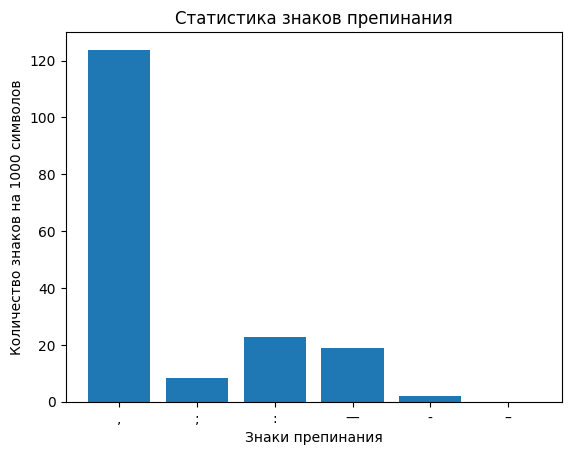

Восклицательные предложения:  497
Вопросительные предложения:  444
Предложения c многоточием :  82
Предложения c точкой :  2242


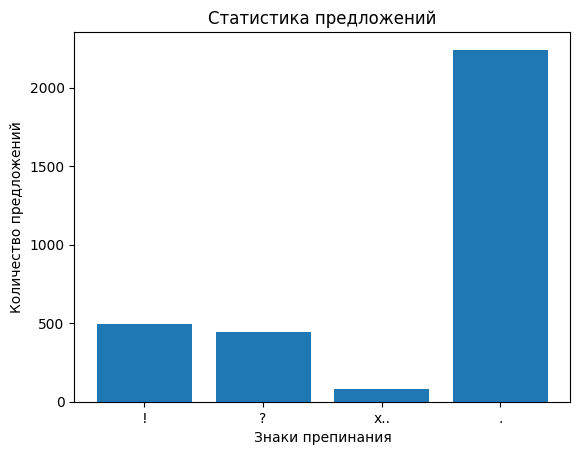

{'Пассивный залог': 0.015,
 'Простое предложение': 0.567,
 'Сложное предложение': 0.433}

In [143]:
d = read_file("Dvoynik.txt")
internal_syntaxis(d)
sentence_type(d)
sentence_complexity(d)




Запятых на 1000 символов:  128.9198606271777
Двоеточий на 1000 символов:  0.0
Дефис на 1000 символов:  0.0
Аналог-дефис на 1000 символов:  4.645760743321719
Тире на 1000 символов:  0.0
Точек с запятой на 1000 символов:  11.614401858304298


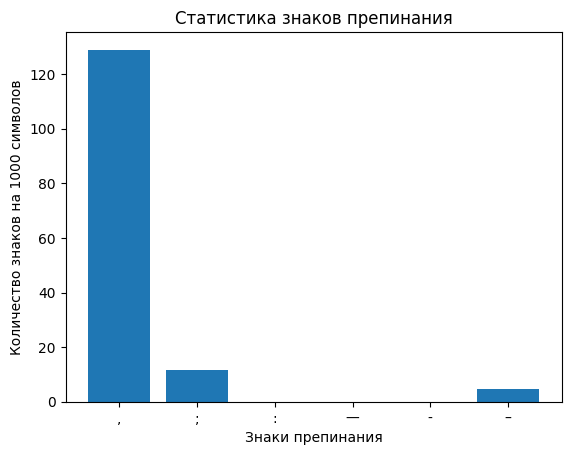

Восклицательные предложения:  25
Вопросительные предложения:  6
Предложения c многоточием :  0
Предложения c точкой :  15


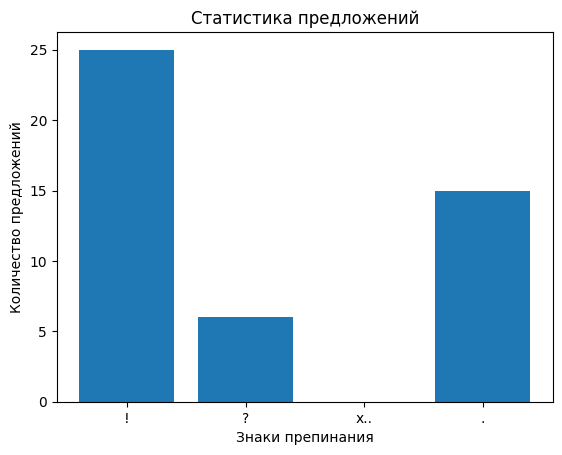

{'Пассивный залог': 0.019,
 'Простое предложение': 0.566,
 'Сложное предложение': 0.434}

In [144]:
p = read_file("na_pervoe.txt")
internal_syntaxis(p)
sentence_type(p)
sentence_complexity(p)


Запятых на 1000 символов:  104.69634471502052
Двоеточий на 1000 символов:  4.0129804482962195
Дефис на 1000 символов:  0.0
Аналог-дефис на 1000 символов:  0.0
Тире на 1000 символов:  39.504705605439135
Точек с запятой на 1000 символов:  5.004649655230959


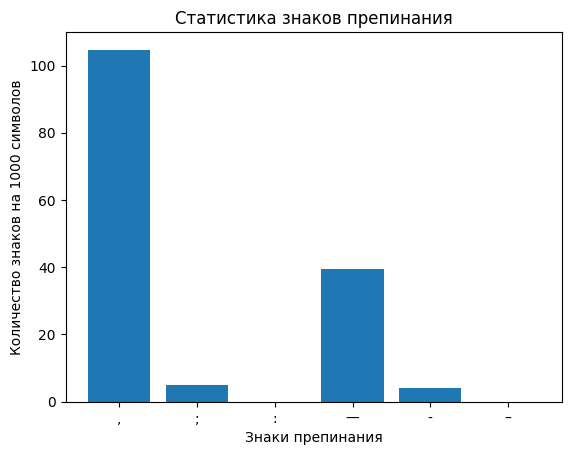

Восклицательные предложения:  3308
Вопросительные предложения:  2287
Предложения c многоточием :  2753
Предложения c точкой :  18630


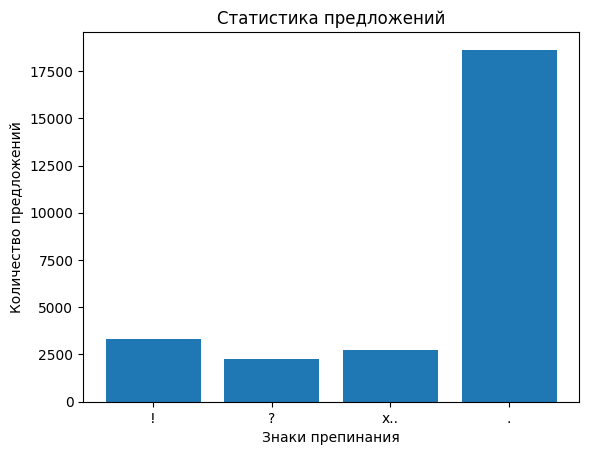

{'Пассивный залог': 0.013,
 'Простое предложение': 0.7,
 'Сложное предложение': 0.3}

In [146]:
pre = read_file("prestuplenie-i-nakazanie.txt")
internal_syntaxis(pre)
sentence_type(pre)
pre = open("prestuplenie-i-nakazanie.txt", 'r').read(1000000)
sentence_complexity(pre)


Запятых на 1000 символов:  105.6963152880303
Двоеточий на 1000 символов:  3.214537455170758
Дефис на 1000 символов:  0.0
Аналог-дефис на 1000 символов:  0.0
Тире на 1000 символов:  37.95090665447982
Точек с запятой на 1000 символов:  6.285776252701373


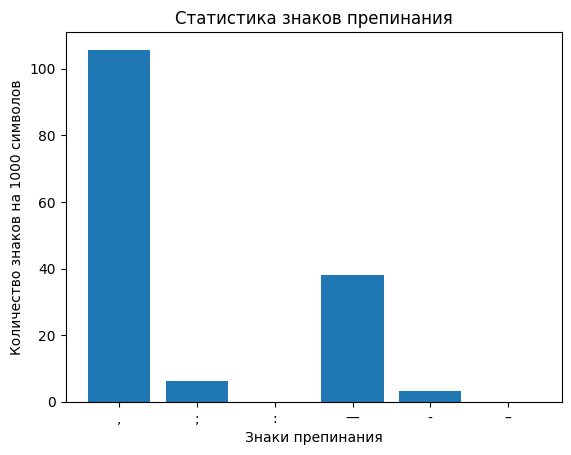

Восклицательные предложения:  1816
Вопросительные предложения:  2332
Предложения c многоточием :  1751
Предложения c точкой :  15868


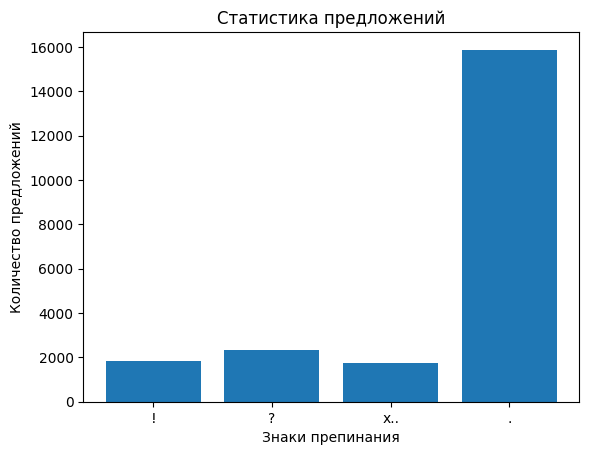

{'Пассивный залог': 0.019,
 'Простое предложение': 0.655,
 'Сложное предложение': 0.345}

In [150]:
b = read_file("besy.txt")
internal_syntaxis(b)
sentence_type(b)
b = open("besy.txt", 'r').read(1000000)
sentence_complexity(b)


Запятых на 1000 символов:  108.25659864385933
Двоеточий на 1000 символов:  5.6155227938439625
Дефис на 1000 символов:  25.330539057822083
Аналог-дефис на 1000 символов:  0.0
Тире на 1000 символов:  9.078698234427847
Точек с запятой на 1000 символов:  7.391613936853689


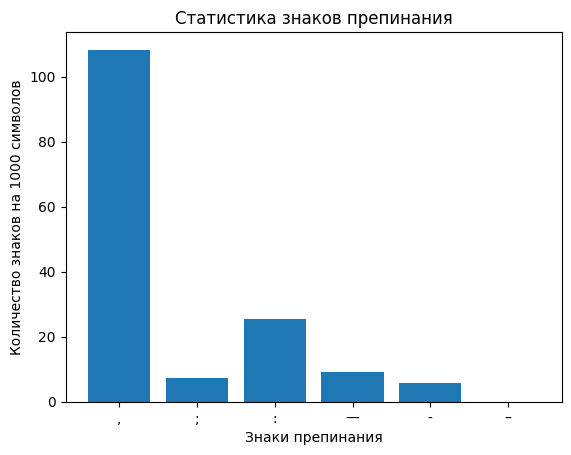

Восклицательные предложения:  1929
Вопросительные предложения:  1884
Предложения c многоточием :  70
Предложения c точкой :  9001


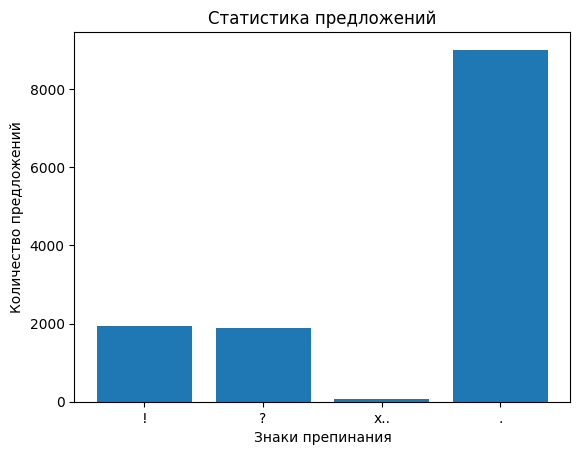

{'Пассивный залог': 0.024,
 'Простое предложение': 0.462,
 'Сложное предложение': 0.538}

In [151]:
pod = read_file("podrostok.txt")
internal_syntaxis(pod)
sentence_type(pod)
pod = open("podrostok.txt", 'r').read(1000000)
sentence_complexity(pod)


Запятых на 1000 символов:  104.41426146010187
Двоеточий на 1000 символов:  3.1833616298811545
Дефис на 1000 символов:  0.0
Аналог-дефис на 1000 символов:  0.0
Тире на 1000 символов:  8.276740237691001
Точек с запятой на 1000 символов:  5.942275042444821


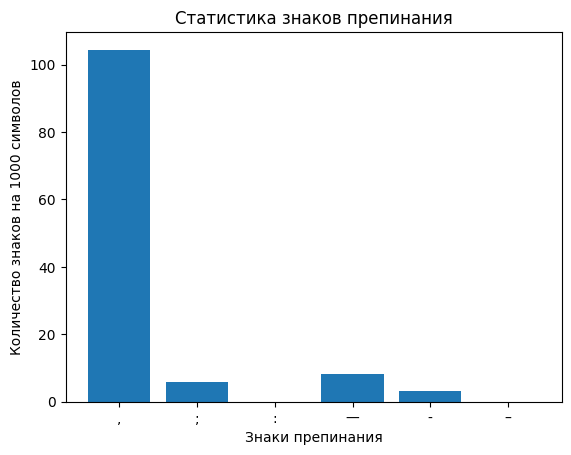

Восклицательные предложения:  25
Вопросительные предложения:  10
Предложения c многоточием :  6
Предложения c точкой :  243


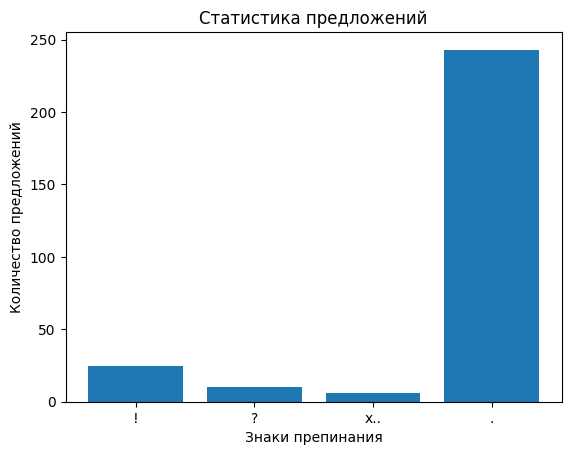

{'Пассивный залог': 0.008,
 'Простое предложение': 0.675,
 'Сложное предложение': 0.325}

In [152]:
push = read_file("pushkin.txt")
internal_syntaxis(push)
sentence_type(push)
sentence_complexity(push)

Интересно, что со врменем доминирующим из неклассических знаков препинания вместо ! стал ?. Однако в последней работе ! очень частый, но это зависит от жанра. Также структура предложений изменилсаь с простых предложений в сторону сложных (опять же исключение Пушкин - но разница не значительная)

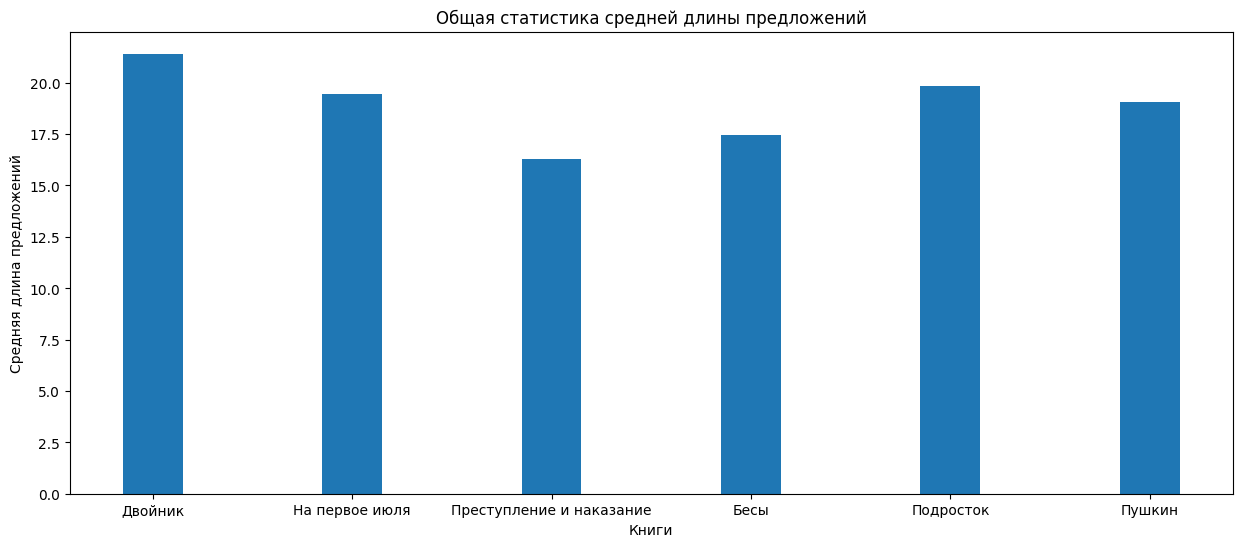

In [139]:
labels = ['Двойник', 'На первое июля', 'Пpеступление и наказание', 'Бесы', 'Подросток', 'Пушкин' ]
counts = [sentence_len(d), sentence_len(p), sentence_len(pre), sentence_len(b), sentence_len(pod), sentence_len(push)]
plt.figure(figsize=(15, 6))
plt.bar(labels, counts, width=0.3)
plt.xlabel('Книги')
plt.ylabel('Средняя длина предложений')
plt.title('Общая статистика средней длины предложений')
plt.show()


Длина предложений постепенно уменьшалась, потом снова возрасла, но осталась ниже начального уровня

In [116]:
d = read_file("Dvoynik.txt")
p = read_file("na_pervoe.txt")
pre = open("prestuplenie-i-nakazanie.txt", 'r').read(1000000)
b = open("besy.txt", 'r').read(1000000)
pod = open("podrostok.txt", 'r').read(1000000)
push = read_file("pushkin.txt")


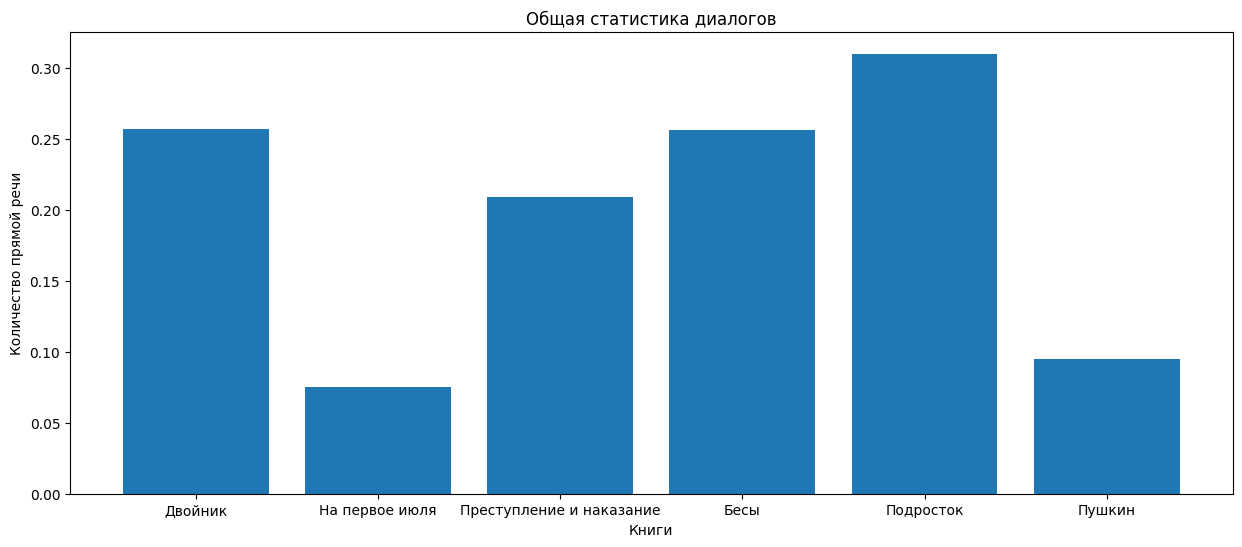

In [68]:

labels = ['Двойник', 'На первое июля', 'Пpеступление и наказание', 'Бесы', 'Подросток', 'Пушкин' ]
counts = [dialog(d), dialog(p), dialog(pre), dialog(b), dialog(pod), dialog(push)]
plt.figure(figsize=(15, 6))
plt.bar(labels, counts)
plt.xlabel('Книги')
plt.ylabel('Количество прямой речи')
plt.title('Общая статистика диалогов')
plt.show()

Кол-во диалогов возросло, а тексты "На первое июля"(стихотворение) и "Пушкин"(письма) - тексты иного жанра, поэтому они не слишком репрезентативны для именно этой выборки. 